In [1]:
import os
import cv2
import shutil
import torch
import torchvision
from torchvision.models.detection import KeypointRCNN
from torchvision.models.detection.anchor_utils import AnchorGenerator
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.distributed as dist
from google.colab import files

In [2]:
torch.manual_seed(22);

In [ ]:
files.upload(); #animals_data.zip

In [3]:
data_dir = '/content/data'

In [6]:
shutil.unpack_archive('/content/animals_data.zip', data_dir)

In [4]:
def features_to_dict(features):
    target_dict = dict()

    target_dict['boxes'] = torch.FloatTensor([[features[5], features[6], features[5] + features[7], features[6] + features[8]]])
    target_dict['labels'] = torch.IntTensor([features[:5].argmax() + 1]).long()
    keypoints_list = list()
    for i in range(9, 67, 3):
      keypoints_list.append([features[i+1], features[i+2], features[i]])

    target_dict['keypoints'] = torch.FloatTensor([keypoints_list])

    return target_dict

In [5]:
class AnimalsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = csv_file
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_idx = self.data.iloc[idx, 0]
        img_name = os.path.join(self.root_dir, "0"*(3-len(str(img_idx))) + str(img_idx) + ".jpeg")
        image = Image.open(img_name)
        features = self.data.iloc[idx, 1:].to_numpy()

        if self.transform:
            image = self.transform(image)

        sample = (image, features_to_dict(features))

        return sample

In [6]:
target_size = (256, 256)

In [7]:
train_transforms = transforms.Compose([
        transforms.Resize(target_size),
        transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)]), p=0.1),
        transforms.RandomApply(torch.nn.ModuleList([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))]), p=0.1),
        torchvision.transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor()
])

df = pd.read_csv(os.path.join(data_dir, 'animals_data.csv'))


# Костыль для скейла данных к target_size
df_dict = df.to_dict()

for column in df.columns:
    if '_x' in column or '_width' in column or '_y' in column or '_height' in column:
        df[column] = df[column].astype(float)

for idx in df_dict['id'].values():
    img_name = os.path.join(data_dir, 'animals', "0"*(3-len(str(idx))) + str(idx) + ".jpeg")
    image = Image.open(img_name)
    x_size, y_size = image.size
    for column in df_dict.keys():
        if '_x' in column or '_width' in column:
            df_dict[column][idx] *= target_size[0]
            df_dict[column][idx] //= x_size
        elif '_y' in column or '_height' in column:
            df_dict[column][idx] *= target_size[1]
            df_dict[column][idx] //= y_size

df = pd.DataFrame.from_dict(df_dict)

dataset = AnimalsDataset(csv_file=df, root_dir=os.path.join(data_dir, 'animals'), transform=train_transforms)

print(f"Экземпляров в датасете: {len(dataset)}")

Экземпляров в датасете: 967


In [8]:
train_set, val_set = torch.utils.data.random_split(dataset, [900, 67])

batch_size = 5
num_workers = 0

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [10]:
# backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# backbone.out_channels = 1280

# backbone = torchvision.models.mobilenet_v3_small(pretrained=True).features
# backbone.out_channels = 576

backbone = torchvision.models.mobilenet_v3_large(pretrained=True).features
backbone.out_channels = 960

anchor_generator = AnchorGenerator(sizes=((16, 32, 64, 128, 256),), aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
keypoint_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=14, sampling_ratio=2)

model = KeypointRCNN(backbone, num_classes=6, num_keypoints=20,
                     rpn_anchor_generator=anchor_generator,
                     box_roi_pool=roi_pooler, keypoint_roi_pool=keypoint_roi_pooler)

model = model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, amsgrad=True, lr=1.0e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [11]:
def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

def reduce_dict(input_dict, average=True):
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

In [12]:
def keypoints_accuracy(output, target):    
    accuracy = 0.
    if len(output['scores']) > 0:
        keypoints_out = (output['keypoints'][0].cpu().detach().numpy())[:, :].reshape(-1, 3)
        keypoints_scores = output['keypoints_scores'][0].numpy()
        keypoints_tgt = (target['keypoints'][0].cpu().detach().numpy())[:, :].reshape(-1, 3)

        num_keypoints = 0
        sum_accs = 0.
        min_score = 1
        for k in range(keypoints_tgt.shape[0]):
            if keypoints_tgt[k, 2] == 1:
                num_keypoints += 1
                if keypoints_out[k, 2] == 1 and keypoints_scores[k] > min_score:
                    sum_accs += 1 - np.sqrt(((keypoints_out[k, 0] - keypoints_tgt[k, 0])/target_size[0])**2 + ((keypoints_out[k, 1] - keypoints_tgt[k, 1])/target_size[1])**2)
        accuracy = sum_accs / num_keypoints

    return accuracy

In [13]:
num_epochs = 20

loss_history = []
acc_history = []

for epoch in range(num_epochs):
    print()
    print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

    for phase in ['train', 'eval']:
        if phase == 'train':
            dataloader = train_dataloader
            if epoch != 0:
                scheduler.step()
            model.train()
        else:
            dataloader = val_dataloader
            model.eval()

        running_loss = 0.
        running_acc = 0.

        for images, targets in tqdm(dataloader):
            images = images.to(device)

            targets_list = list()
            for target_idx in range(len(targets['labels'])):
                targets_list.append(dict())
                for item in targets.items():
                    targets_list[-1][item[0]] = item[1][target_idx].to(device)
            targets = targets_list

            optimizer.zero_grad()

            if phase == 'train':
                with torch.set_grad_enabled(True):
                    loss_dict = model(images, targets)

                    losses = sum(loss for loss in loss_dict.values())
                    loss_dict_reduced = reduce_dict(loss_dict)
                    losses_reduced = sum(loss for loss in loss_dict_reduced.values())
                    loss_value = losses_reduced.item()

                    losses.backward()
                    optimizer.step()

                running_loss += loss_value
            
            else:
                with torch.set_grad_enabled(False):
                    outputs = model(images)
                
                batch_acc = 0.
                for image_idx in range(len(images)):
                    output = outputs[image_idx]
                    target = targets[image_idx]

                    for key in output.keys():
                        output[key] = output[key].cpu()
                    for key in target.keys():
                        target[key] = target[key].cpu()

                    batch_acc += keypoints_accuracy(output, target)

                running_acc += batch_acc / len(images)
        
        if phase == 'train':
            epoch_loss = running_loss / len(dataloader)
            loss_history.append(epoch_loss)

            print('   {} loss: {:.4f}'.format(phase, epoch_loss), flush=True)
        else:
            epoch_acc = running_acc / len(dataloader)
            acc_history.append(epoch_acc)

            print('     {} acc: {:.4f}'.format(phase, epoch_acc), flush=True)


Epoch 0/19:


100%|██████████| 180/180 [02:14<00:00,  1.33it/s]

   train loss: 7.2488



100%|██████████| 14/14 [00:05<00:00,  2.35it/s]

     eval acc: 0.8163

Epoch 1/19:



100%|██████████| 180/180 [02:15<00:00,  1.33it/s]

   train loss: 5.7071



100%|██████████| 14/14 [00:04<00:00,  2.87it/s]

     eval acc: 0.8149

Epoch 2/19:



100%|██████████| 180/180 [02:15<00:00,  1.33it/s]

   train loss: 5.0578



100%|██████████| 14/14 [00:04<00:00,  3.27it/s]

     eval acc: 0.8621

Epoch 3/19:



100%|██████████| 180/180 [02:11<00:00,  1.37it/s]

   train loss: 4.3516



100%|██████████| 14/14 [00:03<00:00,  3.64it/s]

     eval acc: 0.8918

Epoch 4/19:



100%|██████████| 180/180 [02:12<00:00,  1.36it/s]

   train loss: 4.1646



100%|██████████| 14/14 [00:03<00:00,  3.72it/s]

     eval acc: 0.9000

Epoch 5/19:



100%|██████████| 180/180 [02:14<00:00,  1.34it/s]

   train loss: 4.0704



100%|██████████| 14/14 [00:03<00:00,  3.93it/s]

     eval acc: 0.8983

Epoch 6/19:



100%|██████████| 180/180 [02:14<00:00,  1.34it/s]

   train loss: 3.9468



100%|██████████| 14/14 [00:03<00:00,  3.92it/s]

     eval acc: 0.9051

Epoch 7/19:



100%|██████████| 180/180 [02:14<00:00,  1.34it/s]

   train loss: 3.9162



100%|██████████| 14/14 [00:03<00:00,  3.99it/s]

     eval acc: 0.9064

Epoch 8/19:



100%|██████████| 180/180 [02:14<00:00,  1.34it/s]

   train loss: 3.8924



100%|██████████| 14/14 [00:03<00:00,  3.98it/s]

     eval acc: 0.8993

Epoch 9/19:



100%|██████████| 180/180 [02:14<00:00,  1.34it/s]

   train loss: 3.8873



100%|██████████| 14/14 [00:03<00:00,  3.91it/s]

     eval acc: 0.9026

Epoch 10/19:



100%|██████████| 180/180 [02:14<00:00,  1.33it/s]

   train loss: 3.8770



100%|██████████| 14/14 [00:03<00:00,  4.01it/s]

     eval acc: 0.8986

Epoch 11/19:



100%|██████████| 180/180 [02:14<00:00,  1.34it/s]

   train loss: 3.8749



100%|██████████| 14/14 [00:03<00:00,  4.00it/s]

     eval acc: 0.8973

Epoch 12/19:



100%|██████████| 180/180 [02:14<00:00,  1.34it/s]

   train loss: 3.8808



100%|██████████| 14/14 [00:03<00:00,  4.02it/s]

     eval acc: 0.9035

Epoch 13/19:



100%|██████████| 180/180 [02:14<00:00,  1.34it/s]

   train loss: 3.8801



100%|██████████| 14/14 [00:03<00:00,  3.98it/s]

     eval acc: 0.9055

Epoch 14/19:



100%|██████████| 180/180 [02:14<00:00,  1.33it/s]

   train loss: 3.8762



100%|██████████| 14/14 [00:03<00:00,  3.97it/s]

     eval acc: 0.9055

Epoch 15/19:



100%|██████████| 180/180 [02:14<00:00,  1.34it/s]

   train loss: 3.8808



100%|██████████| 14/14 [00:03<00:00,  4.01it/s]

     eval acc: 0.8988

Epoch 16/19:



100%|██████████| 180/180 [02:15<00:00,  1.33it/s]

   train loss: 3.8707



100%|██████████| 14/14 [00:03<00:00,  4.08it/s]

     eval acc: 0.8983

Epoch 17/19:



100%|██████████| 180/180 [02:14<00:00,  1.34it/s]

   train loss: 3.8614



100%|██████████| 14/14 [00:03<00:00,  4.00it/s]

     eval acc: 0.9045

Epoch 18/19:



100%|██████████| 180/180 [02:14<00:00,  1.33it/s]

   train loss: 3.8795



100%|██████████| 14/14 [00:03<00:00,  3.94it/s]

     eval acc: 0.8995

Epoch 19/19:



100%|██████████| 180/180 [02:14<00:00,  1.33it/s]

   train loss: 3.8734



100%|██████████| 14/14 [00:03<00:00,  3.98it/s]

     eval acc: 0.9054


Best loss: 3.8614


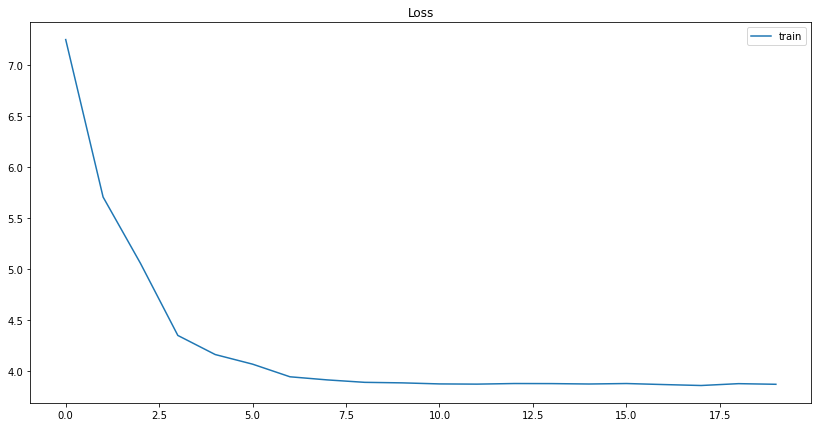


Best acc: 0.9064


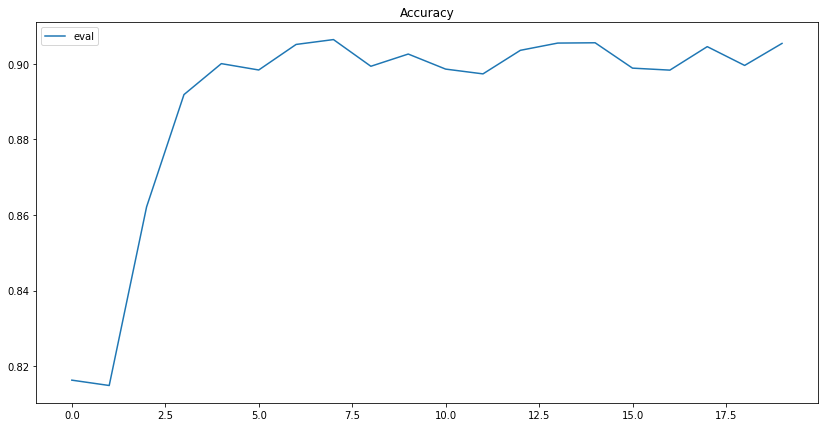

In [16]:
plt.rcParams['figure.figsize'] = (14, 7)
plt.plot(loss_history, label='train')
plt.legend()
plt.title('Loss');
print('Best loss: {:.4f}'.format(min(loss_history)))
plt.show()

# 4.4040 mobilenet_v2
# 3.7580 mobilenet_v3_large
# 3.9252 mobilenet_v3_small
print()

plt.plot(acc_history, label='eval')
plt.legend()
plt.title('Accuracy');
print('Best acc: {:.4f}'.format(max(acc_history)))
plt.show()

In [17]:
 model.eval();

In [ ]:
files.upload(); #test_images.zip

In [22]:
test_data_dir = '/content/data/images'

shutil.unpack_archive('/content/test_images.zip', data_dir)

In [24]:
test_transforms = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
])

test_dataset = []
for img in os.listdir(test_data_dir):
  image = Image.open(os.path.join(test_data_dir, img)).convert('RGB')
  orig_numpy = np.array(image, dtype=np.float32)
  orig_numpy = cv2.cvtColor(orig_numpy, cv2.COLOR_RGB2BGR) / 255.
  image = test_transforms(image)
  image = image.unsqueeze(0).to(device)
  test_dataset.append(image[0])

In [25]:
batch_size = len(os.listdir(test_data_dir))
num_workers = 0

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [26]:
def draw_keypoints(output, image):
    for key in output.keys():
        output[key] = output[key].cpu()

    plt.rcParams['figure.figsize'] = (5, 5)
    plt.figure()
    ax = plt.gca()

    image = image.squeeze().permute(1,2,0)
    plt.imshow(image)
    
    if len(output['scores']) > 0:
        print(output['scores'][0])
        print(output['labels'][0])

        min_score = 1
        keypoints = (output['keypoints'][0].cpu().detach().numpy())[:, :].reshape(-1, 3)
        keypoints_scores = output['keypoints_scores'][0].numpy()
        for k in range(keypoints.shape[0]):
            if keypoints[k, 2] == 1 and keypoints_scores[k] > min_score:
                plt.scatter(int(keypoints[k, 0]), int(keypoints[k, 1]), s=100, marker='.', c='r')

        box = output['boxes'][0]

        rect_x = box[0]
        rect_y = box[1]
        rect_w = box[2] - box[0]
        rect_h = box[3] - box[1]

        rect = patches.Rectangle((rect_x, rect_y), rect_w, rect_h, linewidth=2, edgecolor='cyan', fill = False)
        ax.add_patch(rect)
    
    plt.show()
            

tensor(0.5956)
tensor(1)


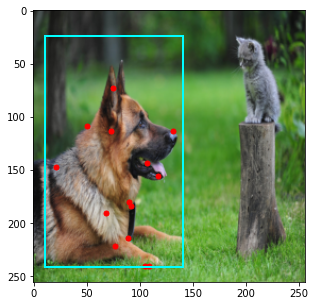

tensor(0.6566)
tensor(5)


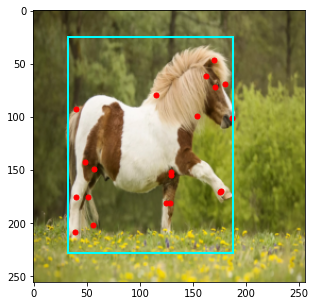

tensor(0.8466)
tensor(1)


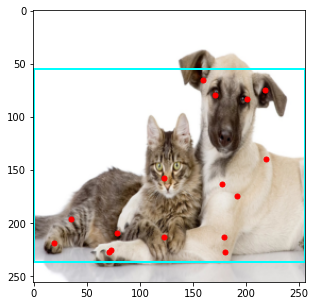

tensor(0.8029)
tensor(1)


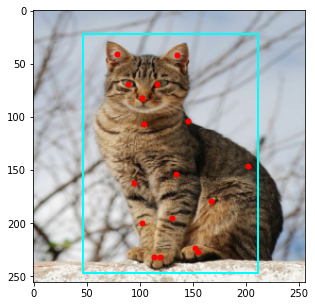

tensor(0.7717)
tensor(4)


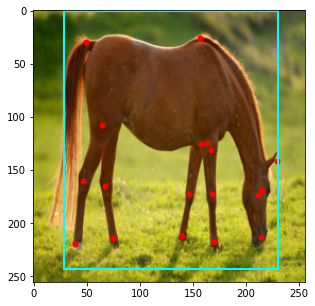

tensor(0.9853)
tensor(5)


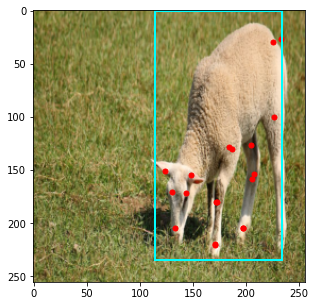

tensor(0.6286)
tensor(1)


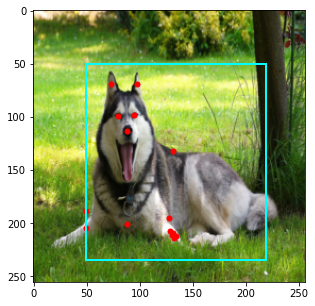

tensor(0.7277)
tensor(3)


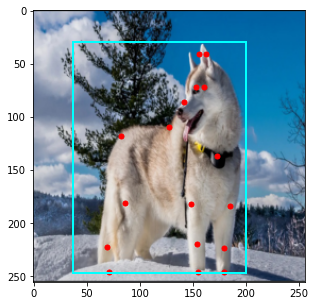

tensor(0.6780)
tensor(3)


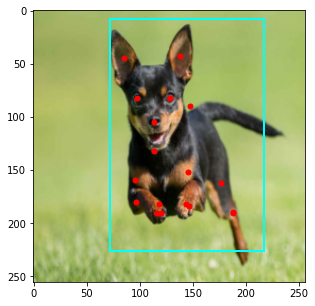

tensor(0.5888)
tensor(3)


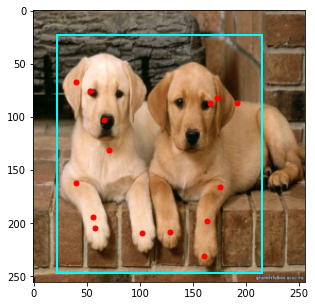

tensor(0.5853)
tensor(3)


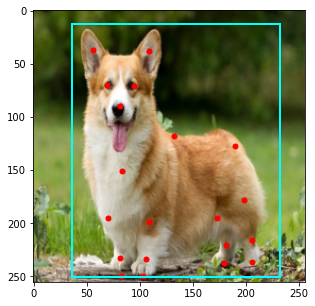

tensor(0.9196)
tensor(5)


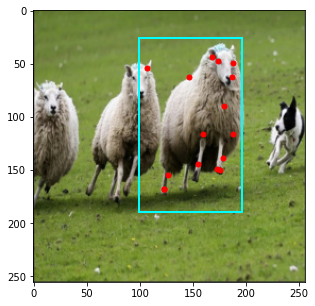

tensor(0.7388)
tensor(4)


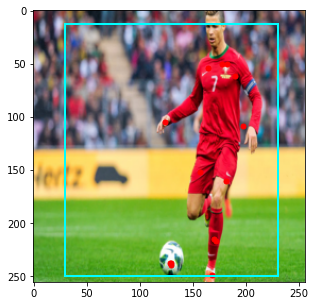

tensor(0.6128)
tensor(1)


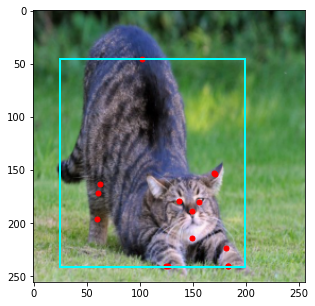

tensor(0.6928)
tensor(1)


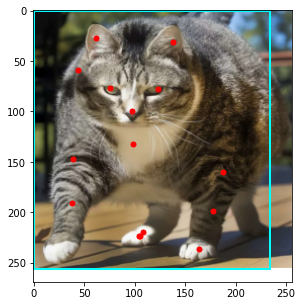

tensor(0.5861)
tensor(3)


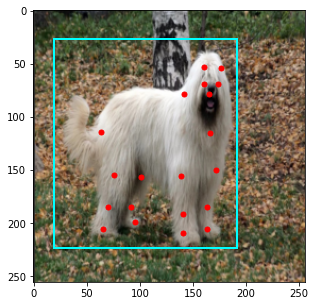

tensor(0.5755)
tensor(4)


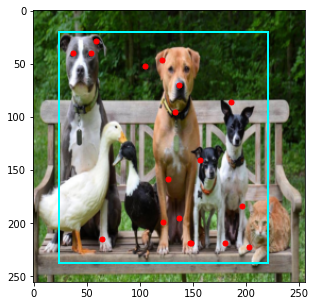

tensor(0.5949)
tensor(4)


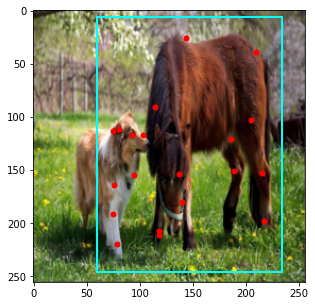

tensor(0.8854)
tensor(1)


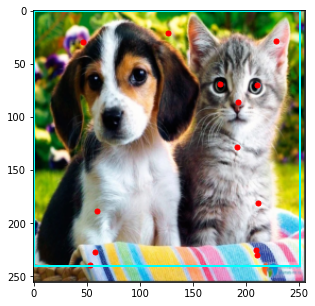

tensor(0.6280)
tensor(4)


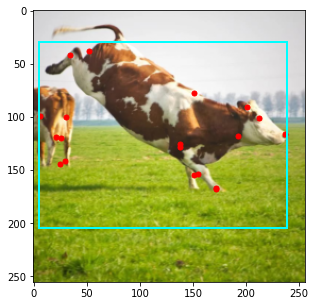

tensor(0.6412)
tensor(2)


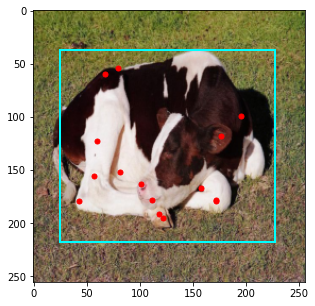

tensor(0.5878)
tensor(4)


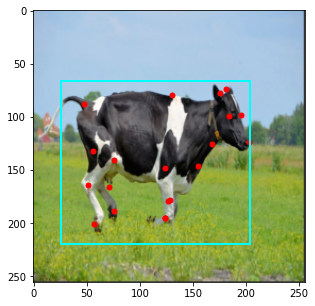

tensor(0.8832)
tensor(1)


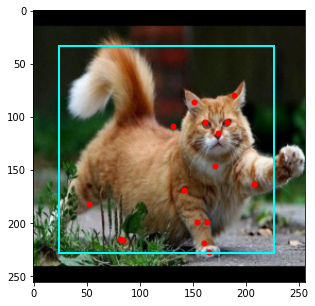

tensor(0.9168)
tensor(4)


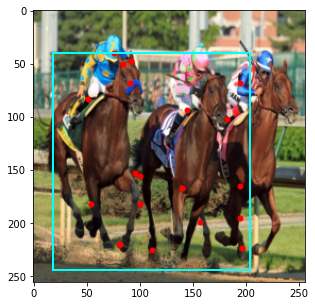

In [27]:
for data in test_dataloader:
    inputs = data.to(device, non_blocking=True)

    with torch.no_grad():
        outputs = model(inputs)

    inputs = inputs.cpu()

    for image_idx in range(len(inputs)):
        output = outputs[image_idx]
        input = inputs[image_idx]

        draw_keypoints(output, input)

In [28]:
torch.save(model.state_dict(), '/content/keypointrcnn_mobilenetv3large_1.pth')